In [1]:
import pandas as pd
from seq2seq import Seq2Seq
from utils import *
from tqdm import tqdm

train = pd.read_csv("news_summary_more.csv")

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
# clean the text in both the columns

x = list(train.text.values)
y = list(train.headlines.values)

for i in tqdm(range(len(train))):
    x[i] = clean_text(x[i])
    y[i] = clean_text(y[i])

100%|██████████████████████████████████████████████████████████████████████████| 65766/65766 [1:11:56<00:00, 15.23it/s]


In [8]:
train = pd.DataFrame({"text":x,"headlines":y})

In [2]:
# get word count for both the columns
train['text_word_count'] = train.text.apply(lambda x: len(x.split()))
train['headlines_word_count'] = train.headlines.apply(lambda x: len(x.split()))

array([[<AxesSubplot:title={'center':'text_word_count'}>,
        <AxesSubplot:title={'center':'headlines_word_count'}>]],
      dtype=object)

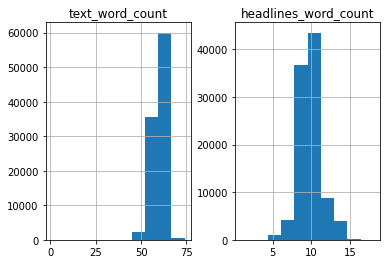

In [3]:
# visualize the word count
train.hist()

In [3]:
# add tokens in summary column to denote the begininnig and end of sentence
train.headlines = train.headlines.apply(lambda x: "<sos> "+x+" <eos>")

64144

In [2]:
# get count of non rare words in both columns
text_total_count = non_rare_word_count(train.text)
headlines_total_count = non_rare_word_count(train.headlines)

In [3]:
# get the length of the longest text in from both columns
text_maxlen = train.text_word_count.max()
headlines_maxlen = train.headlines_word_count.max()

In [4]:
# convert text to sequence data

xtk = Tokenizer(num_words=text_total_count)
xtk.fit_on_texts(train.text.values)
xtrain_seq = xtk.texts_to_sequences(train.text.values)
xtrain_padded = pad_sequences(xtrain_seq,maxlen=text_maxlen,padding='post')
x_voc = xtk.num_words+1

ytk = Tokenizer(num_words=headlines_total_count,filters='')
ytk.fit_on_texts(train.headlines.values)
ytrain_seq = ytk.texts_to_sequences(train.headlines.values)
ytrain_padded = pad_sequences(ytrain_seq,maxlen=headlines_maxlen,padding='post')
y_voc = ytk.num_words+1

In [5]:
print(f"vocabulary size of original text : {x_voc}")
print(f"vocabulary size of summary text : {y_voc}")

vocabulary size of original text : 30980
vocabulary size of summary text : 13545


In [6]:
xtrain_padded.shape,ytrain_padded.shape

((98401, 74), (98401, 18))

In [7]:
xtrain = [xtrain_padded,ytrain_padded[:,:-1]]
ytrain = ytrain_padded.reshape(ytrain_padded.shape[0],ytrain_padded.shape[1],1)[:,1:]

In [8]:
# load pretrained glove embeddings
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
 
glove_embeddings = load_glove_model("glove.6B.100d.txt")

Loading Glove Model
400000 words loaded!


In [9]:
# create embedding matrices

x_emb = np.zeros((x_voc,100))
for w,idx in xtk.word_index.items():
    try: x_emb[idx] = glove_embeddings[w]
    except: pass

y_emb = np.zeros((y_voc,100))
for w,idx in ytk.word_index.items():
    try: y_emb[idx] = glove_embeddings[w]
    except: pass    

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

adam = Adam(learning_rate=3e-4)

es = EarlyStopping(monitor='val_loss',mode='min',patience=2)
chk = ModelCheckpoint("s2s.h5",mode="min", monitor="val_loss", save_best_only=True)
callbacks = [es,chk]

In [11]:
# initialize seq2seq 
s2s = Seq2Seq(emb_dim=100,latent_dim=200, pretrained=True, bi_layers=False)

# build encoder and decoder
s2s.build_encoder(max_input_len=text_maxlen, x_vocab_size=x_voc, trainable=True,
                  pretrained_weights=x_emb, num_layers=3, dropout=0.3)

s2s.build_decoder(y_vocab_size=y_voc, pretrained_weights=y_emb)

# stack encoder and decoder and compile the model
s2s_model = s2s.stack_and_compile(optimizer=adam)
s2s_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 74, 100)      3098000     ['input_1[0][0]']                
                                                                                                  
 encoder_0 (LSTM)               [(None, 74, 200),    240800      ['encoder_embedding[0][0]']      
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                              

In [12]:
# train the model
s2s_model.fit(xtrain,ytrain,batch_size=64,epochs=100,validation_split=0.2,callbacks=callbacks)

Epoch 1/100
1230/1230 [==============================] - 84s 63ms/step - loss: 4.5073 - val_loss: 4.1129
Epoch 2/100
1230/1230 [==============================] - 96s 78ms/step - loss: 4.0696 - val_loss: 3.8621
Epoch 3/100
1230/1230 [==============================] - 100s 81ms/step - loss: 3.7961 - val_loss: 3.6734
Epoch 4/100
1230/1230 [==============================] - 101s 82ms/step - loss: 3.6031 - val_loss: 3.5389
Epoch 5/100
1230/1230 [==============================] - 112s 91ms/step - loss: 3.4493 - val_loss: 3.4324
Epoch 6/100
1230/1230 [==============================] - 119s 97ms/step - loss: 3.3216 - val_loss: 3.3512
Epoch 7/100
1230/1230 [==============================] - 131s 107ms/step - loss: 3.2123 - val_loss: 3.2777
Epoch 8/100
1230/1230 [==============================] - 133s 109ms/step - loss: 3.1141 - val_loss: 3.2218
Epoch 9/100
1230/1230 [==============================] - 139s 113ms/step - loss: 3.0251 - val_loss: 3.1672
Epoch 10/100
1230/1230 [=====================

In [6]:
# save tokenizers

import pickle

with open("xtk.pkl","wb") as f:
    pickle.dump(xtk,f)
    
with open("ytk.pkl","wb") as f:
    pickle.dump(ytk,f)
